## Calculate the heat budget for the HOST grid

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import dask, dask_jobqueue
import dask.distributed as dask_distributed

In [2]:
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

In [3]:
cluster = dask_jobqueue.SLURMCluster(
        # Dask worker size
        cores=32, memory='80GB',
        processes=4, # Dask workers per job
       # SLURM job script things
        queue='base', walltime='03:00:00',
        # Dask worker network and temporary
        interface='ib0', local_directory='./dask_jobqueue_logs'
        )

client = dask_distributed.Client(cluster)
cluster.scale(jobs=1)


In [5]:
!squeue -u smomw379

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          14030053      base dask-wor smomw379  R       1:17      1 nesh-clk489


In [6]:
client

<Client: 'tcp://172.18.4.21:37015' processes=4 threads=32, memory=74.52 GiB>

In [7]:
yCV = range(1002,1107)
xCV = range(1447,1532)

In [8]:
## load time axis
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/MHW_Detection/'
time_counter = xr.open_mfdataset(path + 'VIKING20X.L46-KFS003-6th_1d_*_MHWs-WMO-00.nc').time_counter

## Heat flux

In [9]:
path ='/gxfs_work/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/suppl/1_mesh_mask.nc'
dsM = xr.open_dataset(path).squeeze().rename({'z':'deptht'}).isel(x=xCV, y=yCV)

## grid cell area
A = (dsM.e1t * dsM.e2t).where(dsM.tmask==1).compute()

In [10]:
calc_HFX = False

if calc_HFX:
    path = '/gxfs_work/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003-6th/nemo/output/1d_compressed/'
    HFX_mn = np.zeros((15706))

    tc=0
    for yr in range(1980,2023):
        dsT = xr.open_dataset(path + f'1_VIKING20X.L46-KFS003-6th_1d_{yr}0101_{yr}1231_grid_T.nc').isel(x=xCV_N,y=yCV_N)

        ## heat flux integrated over the area
        lt = len(dsT.time_counter)
        HFX = dsT.sohefldo
        HFX_mn[tc:tc+lt] = (HFX * dsM.e1t * dsM.e2t).sum(('x','y')).compute()
        tc+=lt

        print(yr, end=' ')

    ## save output
    HFX_mn = xr.DataArray(HFX_mn).rename({'dim_0':'time_counter'}).assign_coords({'time_counter':time_counter})
    ds_out = xr.Dataset(data_vars = {'HFX_mn':HFX_mn})
    ds_out.to_netcdf('/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/1_VIKING20X.L46-KFS003-6th_1d_19800101_20221231_HFX-CapeVerde.nc')
else:
    ## load integrated heat flux if it exists
    dsHFX = xr.open_dataset('/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/1_VIKING20X.L46-KFS003-6th_1d_19800101_20221231_HFX-CapeVerde.nc')


In [11]:
## calculate climatology

def daily_clim(hfx,doy): 

    ## for each day of the year get list of indices from full timeseries 
    doys = np.arange(doy-5,doy+6) # Hobday et al. (2016): take +- 5 days

    doys[doys<1]   = 366 + doys[doys<1] # include last/first days of year at beginning/end of year
    doys[doys>366] = doys[doys>366] - 366
    # get the indices in a sorted array
    ind_doy = np.array([])

    for xx in range(0,11):
      ind_doy = np.append(ind_doy, np.where(dsHFX.time_counter.dt.dayofyear == doys[xx])[0])
    ind_doy = np.sort(ind_doy).astype(int)

    ## temperature at doy from all years
    HFX_doy = hfx.isel(time_counter=ind_doy)

    ## average temperature for doy
    HFX_clim = HFX_doy.mean('time_counter').compute()

    ## standard deviation temperature for doy
    HFX_std = HFX_doy.std('time_counter').compute()

    return HFX_clim, HFX_std

In [12]:
HFX_clim = xr.DataArray(np.zeros((366))).rename('seas').rename({'dim_0':'doy'})
HFX_std  = xr.DataArray(np.zeros((366))).rename('std').rename({'dim_0':'doy'})

for doy in range(0,366):
    HFX_clim[doy], HFX_std[doy] = daily_clim(dsHFX.HFX_mn, doy)

In [13]:
## calculate anomaly from daily climatology
HFX_ano = np.array([]); 

for yr in range(1980,2022+1):
    HFX_yr = dsHFX.HFX_mn.groupby('time_counter.year')[yr]

    ## keep the mean heat flux
    if len(HFX_yr)==366:
    
        HFX_ano = np.append(HFX_ano, (HFX_yr.groupby('time_counter.dayofyear') 
                                     - HFX_clim.rename({'doy':'dayofyear'})).compute() + HFX_clim.mean())
        
    else:
        HFX_ano = np.append(HFX_ano, (HFX_yr.groupby('time_counter.dayofyear') 
                                     - HFX_clim[0:-1].rename({'doy':'dayofyear'})).compute() + HFX_clim[0:-1].mean())

In [14]:
HFX_ano = xr.DataArray(HFX_ano).rename({'dim_0':'time_counter'}).assign_coords({'time_counter':time_counter})

In [15]:
## cumulative heatflux 
HFX_ano_cum = (HFX_ano*24*3600).cumsum()

## oceanic heat transport

In [16]:
## load ocean heat transport
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/'
dsOHT = xr.open_mfdataset(path+'1_VIKING20X.L46-KFS003-6th_1d_*_OHT_CapeVerde.nc', chunks={'time_counter':1})

In [17]:
## combine sections
OHT_net = (-dsOHT.OHT_E+dsOHT.OHT_W+dsOHT.OHT_S-dsOHT.OHT_N).compute()

/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 10.27 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [18]:
## calculate climatology

def daily_clim(hfx,doy): 

    ## for each day of the year get list of indices from full timeseries 
    doys = np.arange(doy-5,doy+6) # Hobday et al. (2016): take +- 5 days

    doys[doys<1]   = 366 + doys[doys<1] # include last/first days of year at beginning/end of year
    doys[doys>366] = doys[doys>366] - 366
    # get the indices in a sorted array
    ind_doy = np.array([])
    for xx in range(0,11):
      ind_doy = np.append(ind_doy, np.where(time_counter.dt.dayofyear == doys[xx])[0])
    ind_doy = np.sort(ind_doy).astype(int)

    ## temperature at doy from all years
    HFX_doy = hfx.isel(time_counter=ind_doy)

    ## average temperature for doy
    HFX_clim = HFX_doy.mean('time_counter').compute()

    ## standard deviation temperature for doy
    HFX_std = HFX_doy.std('time_counter').compute()

    return HFX_clim, HFX_std

In [19]:
OHT_clim = xr.DataArray(np.zeros((366,46))).rename('seas').rename({'dim_0':'doy', 'dim_1':'deptht'})
OHT_std  = xr.DataArray(np.zeros((366,46))).rename('std').rename({'dim_0':'doy', 'dim_1':'deptht'})

for doy in range(0,366):
    OHT_clim[doy,:], OHT_std[doy,:] = daily_clim(OHT_net, doy)

In [20]:
## calculate anomaly from daily climatology
OHT_ano = np.zeros((15706,46)); 
tc=0

for yr in range(1980,2022+1):
    OHT_yr = OHT_net.groupby('time_counter.year')[yr]

    if len(OHT_yr)==366:
    
        OHT_ano[tc:tc+366,:] =  (OHT_yr.groupby('time_counter.dayofyear') 
                                     - OHT_clim.rename({'doy':'dayofyear'})).compute() + OHT_clim.mean('doy')
        tc+=366
    else:
        OHT_ano[tc:tc+365,:] = (OHT_yr.groupby('time_counter.dayofyear') 
                                     - OHT_clim[0:-1,:].rename({'doy':'dayofyear'})).compute() + OHT_clim[0:-1,:].mean('doy')
        tc+=365

In [21]:
OHT_ano = xr.DataArray(OHT_ano).rename({'dim_0':'time_counter', 'dim_1':'deptht'}).assign_coords({'time_counter':time_counter})

In [22]:
## cumulative sum
OHT_ano_cum = ((OHT_ano)*24*3600).cumsum('time_counter')

## Vertical heat transport

In [23]:
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/'
dsWT = xr.open_mfdataset(path + f'1_VIKING20X.L46-KFS003-6th_1d_*_OHT-Vert_CapeVerde.nc')

In [24]:
OHT_Vert_clim = xr.DataArray(np.zeros((366,45))).rename('seas').rename({'dim_0':'doy', 'dim_1':'deptht'})
OHT_Vert_std  = xr.DataArray(np.zeros((366,45))).rename('std').rename({'dim_0':'doy', 'dim_1':'deptht'})

for doy in range(0,366):
    OHT_Vert_clim[doy,:], OHT_Vert_std[doy,:] = daily_clim(dsWT.OHT_vert, doy)

In [25]:
## anomaly from daily climatology
OHT_Vert_ano = np.zeros((15706,45)); 
tc=0

for yr in range(1980,2022+1):
    OHT_Vert_yr = dsWT.OHT_vert.groupby('time_counter.year')[yr]

    if len(OHT_Vert_yr)==366:
    
        OHT_Vert_ano[tc:tc+366,:] =  (OHT_Vert_yr.groupby('time_counter.dayofyear') 
                                     - OHT_Vert_clim.rename({'doy':'dayofyear'})).compute() 
        tc+=366
    else:
        OHT_Vert_ano[tc:tc+365,:] = (OHT_Vert_yr.groupby('time_counter.dayofyear') 
                                     - OHT_Vert_clim[0:-1].rename({'doy':'dayofyear'})).compute() 
        tc+=365

OHT_Vert_ano = xr.DataArray(OHT_Vert_ano).rename({'dim_0':'time_counter', 'dim_1':'deptht'})

## Heat content

In [26]:
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/'
dsOHC = xr.open_mfdataset(path+'1_VIKING20X.L46-KFS003-6th_1d_*_OHC_CapeVerde.nc', chunks={'time_counter':1}).load()

In [27]:
OHC_clim = xr.DataArray(np.zeros((366,46))).rename('seas').rename({'dim_0':'doy', 'dim_1':'deptht'})
OHC_std  = xr.DataArray(np.zeros((366,46))).rename('std').rename({'dim_0':'doy', 'dim_1':'deptht'})

for doy in range(0,366):
    OHC_clim[doy,:], OHC_std[doy,:] = daily_clim(dsOHC.OHC, doy)

In [28]:
## anomaly from daily climatology
OHC_ano = np.zeros((15706,46)); 
tc=0

for yr in range(1980,2022+1):
    OHC_yr = dsOHC.OHC.groupby('time_counter.year')[yr]

    if len(OHC_yr)==366:
    
        OHC_ano[tc:tc+366,:] =  (OHC_yr.groupby('time_counter.dayofyear') 
                                     - OHC_clim.rename({'doy':'dayofyear'})).compute() 
        tc+=366
    else:
        OHC_ano[tc:tc+365,:] = (OHC_yr.groupby('time_counter.dayofyear') 
                                     - OHC_clim[0:-1].rename({'doy':'dayofyear'})).compute() 
        tc+=365

OHC_ano = xr.DataArray(OHC_ano).rename({'dim_0':'time_counter', 'dim_1':'deptht'})

In [29]:
# calculate heat content change
dOHC_ano = OHC_ano.differentiate('time_counter')/(24*3600)

dOHC = dsOHC.OHC.drop('time_counter').differentiate('time_counter')/(24*3600)

/tmp/ipykernel_2741262/4217206456.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  dOHC = dsOHC.OHC.drop('time_counter').differentiate('time_counter')/(24*3600)


## Correlation profiles

In [30]:
## calculate residual budget term
Residual = np.zeros((15706, 46))

for zz in range(0,46):
    if (zz>0) & (zz<45):
        Residual[:,zz] = dOHC_ano.isel(deptht=zz) - (OHT_ano.isel(deptht=zz) + (-OHT_Vert_ano.isel(deptht=zz-1) + OHT_Vert_ano.isel(deptht=zz)))
    elif zz==0:
        Residual[:,zz] = dOHC_ano.isel(deptht=zz) - (OHT_ano.isel(deptht=zz) + OHT_Vert_ano.isel(deptht=zz) + HFX_ano)
    elif zz==45:
        Residual[:,zz] = dOHC_ano.isel(deptht=zz) - (OHT_ano.isel(deptht=zz) - OHT_Vert_ano.isel(deptht=zz-1))

Residual = xr.DataArray(Residual).rename({'dim_0':'time_counter', 'dim_1':'deptht'})

In [32]:
# correlation between heat budget change and budget terms

## filter length in days
flen = 10 # remove very high frequency signals

cor_OHT = np.zeros((46))
cor_OHT_Vert = np.zeros((46))
cor_RES = np.zeros((46))

for zz in range(0,46):
    cor_OHT[zz] = np.corrcoef(OHT_ano.isel(deptht=zz).rolling({'time_counter':flen},center=True).mean()[365:-365], 
                                dOHC_ano.isel(deptht=zz).rolling({'time_counter':flen},center=True).mean()[365:-365])[0,1]

for zz in range(0,46):
    cor_RES[zz] = np.corrcoef(Residual.isel(deptht=zz).rolling({'time_counter':flen},center=True).mean()[365:-365], 
                                dOHC_ano.isel(deptht=zz).rolling({'time_counter':flen},center=True).mean()[365:-365])[0,1]

for zz in range(0,46):
    if zz==0:
        cor_OHT_Vert[zz] = np.corrcoef((OHT_Vert_ano.isel(deptht=zz)).rolling({'time_counter':flen},center=True).mean()[365:-365] , 
                                        dOHC_ano.isel(deptht=zz).rolling({'time_counter':flen},center=True).mean()[365:-365])[0,1]
    elif zz==45:
        cor_OHT_Vert[zz] = np.corrcoef((-OHT_Vert_ano.isel(deptht=zz-1)).rolling({'time_counter':flen},center=True).mean()[365:-365] , 
                                        dOHC_ano.isel(deptht=zz).rolling({'time_counter':flen},center=True).mean()[365:-365])[0,1]
    else:
        cor_OHT_Vert[zz] = np.corrcoef((-OHT_Vert_ano.isel(deptht=zz-1) + OHT_Vert_ano.isel(deptht=zz)).rolling({'time_counter':flen},center=True).mean()[365:-365] , 
                                        dOHC_ano.isel(deptht=zz).rolling({'time_counter':flen},center=True).mean()[365:-365])[0,1]

/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/pytho

In [33]:
cor_HFX = np.corrcoef(HFX_ano, dOHC_ano.isel(deptht=0))[0,1]

### mean profiles

In [34]:
## mean vertical heat transport (account for bottom and surface)
vert_mn = np.zeros((46))

vert_mn[1:-1] = dsWT.OHT_vert.diff('deptht').mean('time_counter')
vert_mn[0] = dsWT.OHT_vert.isel(deptht=0).mean('time_counter')
vert_mn[-1] = -dsWT.OHT_vert.isel(deptht=44).mean('time_counter')

In [35]:
## mean residual 
Residual_mn = dOHC.mean('time_counter') - (OHT_net.mean('time_counter') + vert_mn)

### MHW Area

In [36]:
## load time axis
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/MHW_Detection/'
time_counter = xr.open_mfdataset(path +  'VIKING20X.L46-KFS003-6th_1d_*_MHWs-WMO-00.nc').time_counter

In [37]:
dpt = dsOHT.deptht

In [38]:
## use host grid here
yCV_H = range(554,575)
xCV_H = range(295,312) 

In [39]:
## grid cell area
path ='/gxfs_work/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/suppl/mesh_mask.nc'
dsMH = xr.open_dataset(path).squeeze().isel(x=range(750,1250)).isel(x=xCV_H,y=yCV_H).rename({'z':'deptht'})

AH = (dsMH.e1t * dsMH.e2t).where(dsMH.tmask==1).compute()

In [40]:
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/MHW_Detection/'

In [41]:
## WMO: calculate MHW area
MHW_Area = np.zeros((15706,46))
tc=0
for yr in range(1980,2023):
    for zz in range(0,46):
        if zz<10:
            zin = f'0{zz}'
        else:
            zin = str(zz)
        
        ds = xr.open_dataset(path+f'VIKING20X.L46-KFS003-6th_1d_{yr}0101_{yr}1231_MHWs-WMO-{zin}.nc').isel(x=xCV_H,y=yCV_H)

        lt = len(ds.time_counter)

        MHW_Area[tc:tc+lt,zz] =  (ds.mhw_mask * AH.isel(deptht=zz)).sum(('x','y')) / AH.isel(deptht=zz).sum(('x','y'))
    tc+=lt

MHW_Area = xr.DataArray(MHW_Area).rename({'dim_0':'time_counter', 'dim_1':'deptht'}).assign_coords({'time_counter':time_counter})

In [42]:
## Linear: calculate MHW area 
MHW_Area_lin = np.zeros((15706,46))
tc=0
for yr in range(1980,2023):
    for zz in range(0,46):
        if zz<10:
            zin = f'0{zz}'
        else:
            zin = str(zz)
        
        ds = xr.open_dataset(path+f'VIKING20X.L46-KFS003-6th_1d_{yr}0101_{yr}1231_MHWs-detrend-{zin}.nc').isel(x=xCV_H,y=yCV_H)

        lt = len(ds.time_counter)

        MHW_Area_lin[tc:tc+lt,zz] =  (ds.mhw_mask * AH.isel(deptht=zz)).sum(('x','y')) / AH.isel(deptht=zz).sum(('x','y'))
    tc+=lt

MHW_Area_lin = xr.DataArray(MHW_Area_lin).rename({'dim_0':'time_counter', 'dim_1':'deptht'}).assign_coords({'time_counter':time_counter})

## Mean temperature gradients

In [43]:
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/EKE/'
## temperature
dsT = xr.open_mfdataset(path + f'1_VIKING20X.L46-KFS003-6th_1y_*_grid_T.nc'
                     ).isel(x=xCV, y=yCV)  

In [44]:
## vertical gradient
T_mn = dsT.votemper.where(dsT.votemper!=0).mean(('time_counter','x','y'))
T_grad_z = T_mn.diff('deptht').compute() / dsM.e3w_1d[1:]

In [45]:
yCVex = range(1002-50,1107+50)
xCVex = range(1447-50,1532+50)

## load mask
path = '/gxfs_work/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/suppl/'
dsM = xr.open_dataset(path+'1_mesh_mask.nc').isel(x=xCVex,y=yCVex).squeeze()

## temperature
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/EKE/'
dsT = xr.open_mfdataset(path+f'1_VIKING20X.L46-KFS003-6th_1y_*_grid_T.nc'
                     ).isel(x=xCVex, y=yCVex)  

In [46]:
## horizontal gradient
T_mn = dsT.votemper.mean('time_counter').compute()
T_mn = T_mn.where(T_mn!=0)

T_grad_W = T_mn.differentiate(('x')).isel(x=50,y=range(50,50+len(yCV))) / dsM.e1t.isel(x=50, y=range(50,50+len(yCV)))

T_grad_E = T_mn.differentiate(('x')).isel(x=50+len(xCV), y=range(50,50+len(xCV))) / dsM.e1t.isel(x=50+len(xCV), y=range(50,50+len(xCV)))

T_grad_S = T_mn.differentiate(('y')).isel(y=50, x=range(50,50+len(xCV))) / dsM.e2t.isel(y=50, x=range(50,50+len(xCV)))
T_grad_N = T_mn.differentiate(('y')).isel(y=50+len(yCV), x=range(50,50+len(xCV))) / dsM.e2t.isel(y=50, x=range(50,50+len(xCV)))


/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 52.26 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [47]:
## horizontal gradient across boundary of domain
T_grad_hor = xr.concat([-T_grad_W.rename({'y':'c'}),
                         T_grad_N.rename({'x':'c'}),
                         T_grad_E.rename({'y':'c'}),
                        -T_grad_S.rename({'x':'c'}) 
                       ], dim='c') 

T_grad_hor_mn = T_grad_hor.mean('c')

## Mean velocity profiles

In [48]:
## zonal and meridional velocity
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/EKE/'
files = [path+f'1_VIKING20X.L46-KFS003-6th_1y_{yr}0101_{yr}1231_grid_U.nc' for yr in range(1980,2023)]
dsU = xr.open_mfdataset(files).isel(x=xCV, y=yCV) 

files = [path+f'1_VIKING20X.L46-KFS003-6th_1y_{yr}0101_{yr}1231_grid_V.nc' for yr in range(1980,2023)]
dsV = xr.open_mfdataset(files).isel(x=xCV, y=yCV)  

In [49]:
## time mean
U_mn = dsU.vozocrtx.mean('time_counter').rename({'depthu':'deptht'}).compute()
V_mn = dsV.vomecrty.mean('time_counter').rename({'depthv':'deptht'}).compute()

/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 52.22 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 52.22 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [50]:
## speed across boundary of domain
speed = (U_mn**2 + V_mn**2)**2 

speed_W =  speed.isel(x=0)
speed_E =  speed.isel(x=len(xCV)-1)
speed_S =  speed.isel(y=0)
speed_N =  speed.isel(y=len(yCV)-1)

In [51]:
speed_sec = xr.concat([speed_W.rename({'y':'c'}),
                       speed_N.rename({'x':'c'}),
                       speed_E.rename({'y':'c'}),
                       speed_S.rename({'x':'c'}) 
                       ], dim='c') 

speed_sec_mn = speed_sec.mean('c')

In [52]:
## vertical velocity
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/EKE/TMP/'

W = np.zeros((46))
for z in range(0,40):
    dsW = xr.open_mfdataset(path+f'1_VIKING20X.L46-KFS003-6th_1y_*1231_grid_W-z{z}.nc').isel(y=yCV, x=xCV)
    W[z] = dsW.vovecrtz.mean(('x','y','time_counter')).compute()
    print(z, end='')

0123456789101112131415161718192021222324252627282930313233343536373839

## Plotting

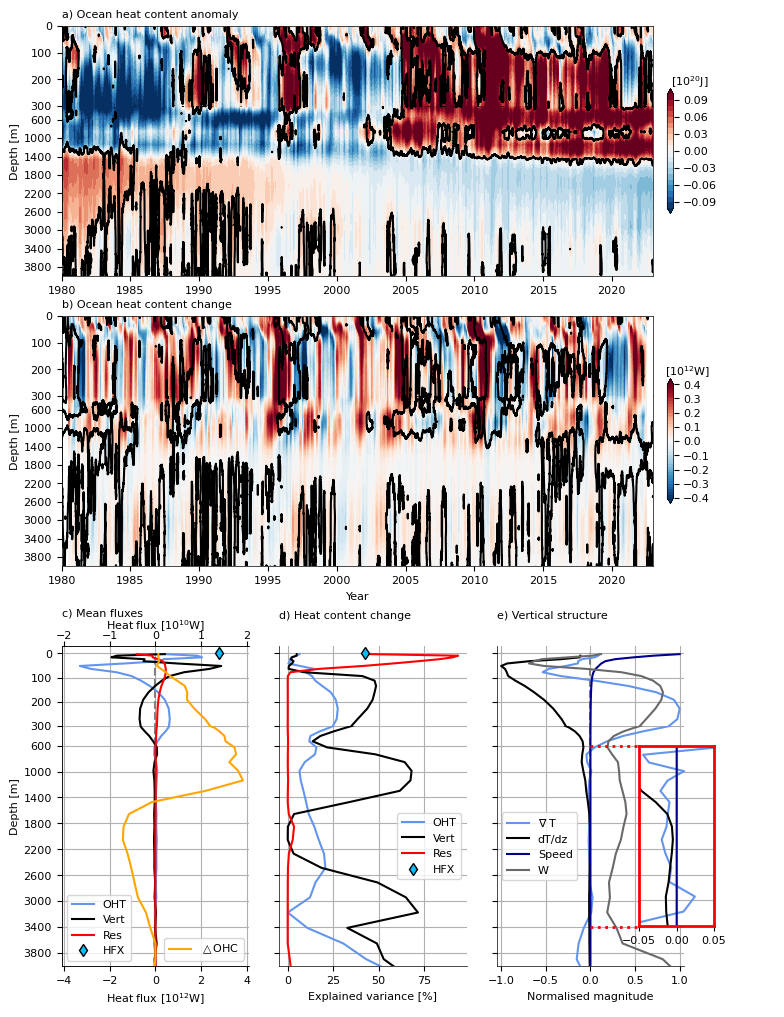

In [54]:
fig = plt.figure(figsize=(7.5,10))
matplotlib.rcParams['axes.linewidth'] = 0.5

ax1L = fig.add_axes([0.08,0.73,0.95,0.25], frameon=False); ax1L.set_xticks([]); ax1L.set_yticks([])
ax1 = fig.add_axes([0.08,0.9,0.95,0.08]); ax1.spines[['bottom']].set_visible(False); ax1.set_xticks([])
ax11 = fig.add_axes([0.08,0.73,0.95,0.17]); ax11.spines[['top']].set_visible(False);

ax2L = fig.add_axes([0.08,0.44,0.95,0.25], frameon=False); ax2L.set_xticks([]); ax2L.set_yticks([])
ax2 = fig.add_axes([0.08,0.61,0.95,0.08]); ax2.spines[['bottom']].set_visible(False); ax2.set_xticks([])
ax21 = fig.add_axes([0.08,0.44,0.95,0.17]); ax21.spines[['top']].set_visible(False);

ax31 = fig.add_axes([0.08,0.28,0.25,0.08], clip_on=False);  ax31.spines[['right','bottom']].set_visible(False); ax31.set_xticklabels([]); ax31.tick_params(bottom=False)
ax3 = fig.add_axes([0.08,0.04,0.25,0.24], clip_on=False);  ax3.spines[['top','right']].set_visible(False);
ax3L = fig.add_axes([0.08,0.04,0.25,0.32], frameon=False); ax3L.set_yticks([]); ax3L.set_xticks([])

ax41 = fig.add_axes([0.37,0.28,0.25,0.08], clip_on=False);  ax41.spines[['top','right','bottom']].set_visible(False); ax41.set_xticklabels([])
ax4 = fig.add_axes([0.37,0.04,0.25,0.24], clip_on=False);  ax4.spines[['top','right']].set_visible(False);

ax51 = fig.add_axes([0.66,0.28,0.25,0.08], clip_on=False);  ax51.spines[['top','right','bottom']].set_visible(False); ax51.set_xticklabels([])
ax5 = fig.add_axes([0.66,0.04,0.25,0.24], clip_on=False);  ax5.spines[['top','right']].set_visible(False);

##
ctf = ax1.contourf(time_counter, -dpt, OHC_ano.where(OHC_ano!=0).T/1e20, levels=np.arange(-0.1,0.11,0.01), cmap='RdBu_r', extend='both')
ax1.set_ylim(-300,0)
ax1.contour(time_counter, -dpt, MHW_Area.T*100, levels=[15], colors='k')
ax1.set_xlim(np.datetime64('1980-01-01'), np.datetime64('2022-12-31'))
ax1.set_yticks(np.arange(-300,10,100)); ax1.set_yticklabels(np.arange(300,-10,-100));

ax11.contourf(time_counter, -dpt, OHC_ano.where(OHC_ano!=0).T/1e20, levels=np.arange(-0.1,0.11,0.01), cmap='RdBu_r', extend='both')
ax11.set_ylim(-4000,-300)
ax11.contour(time_counter, -dpt, MHW_Area.T*100, levels=[15], colors='k')
ax11.set_xlim(np.datetime64('1980-01-01'), np.datetime64('2022-12-31'))
ax11.set_yticks(np.arange(-3800,-590,400)); ax11.set_yticklabels(np.arange(3800,590,-400));

ax1.set_title('a) Ocean heat content anomaly', fontsize=8, loc='left')
ax1L.set_ylabel('Depth [m]', fontsize=8, labelpad=30)

cb = plt.colorbar(ctf, ax=[ax1,ax11], orientation='vertical', shrink=0.5, pad =0.02)
cb.set_label('[$10^{20}$J]', y=1.18, rotation=0, labelpad=-20, fontsize=8)


##
ctf = ax2.contourf(time_counter, -dpt, dOHC_ano.rolling({'time_counter':1*365},center=True).mean().T/1e12, levels=np.arange(-0.4,0.42,0.02), cmap='RdBu_r', extend='both')
ax2.set_ylim(-300,0)
ax2.contour(time_counter, -dpt, MHW_Area_lin.T*100, levels=[15], colors='k')
ax2.set_xlim(np.datetime64('1980-01-01'), np.datetime64('2022-12-31'))
ax2.set_yticks(np.arange(-300,10,100)); ax2.set_yticklabels(np.arange(300,-10,-100));

ax21.contourf(time_counter, -dpt, dOHC_ano.rolling({'time_counter':1*365},center=True).mean().T/1e12, levels=np.arange(-0.4,0.42,0.02), cmap='RdBu_r', extend='both')
ax21.set_ylim(-4000,-300)
ax21.contour(time_counter, -dpt, MHW_Area_lin.T*100, levels=[15], colors='k')
ax21.set_xlim(np.datetime64('1980-01-01'), np.datetime64('2022-12-31'))
ax21.set_yticks(np.arange(-3800,-590,400)); ax21.set_yticklabels(np.arange(3800,590,-400));

ax2.set_title('b) Ocean heat content change', fontsize=8, loc='left')
ax21.set_xlabel('Year', fontsize=8)
ax2L.set_ylabel('Depth [m]', fontsize=8, labelpad=30)
cb = plt.colorbar(ctf, ax=[ax2,ax21], orientation='vertical', shrink=0.5, pad=0.02)
cb.set_label('[$10^{12}$W]', y=1.18, rotation=0, labelpad=-16, fontsize=8)

############

##
ax31.vlines(0, -4000, 0, color='grey', ls='--')
ax31.plot(OHT_net.mean('time_counter')/1e12,  -dsOHT.deptht, 'cornflowerblue', label='OHT')
ax31.plot(vert_mn/1e12,  -dsOHT.deptht, 'k', label='Vert')
ax31.plot(Residual_mn/1e12, -dsOHT.deptht, 'r', label='Res')
ax31.plot(dsHFX.HFX_mn.mean('time_counter')/1e12, 0, marker='d', mfc='deepskyblue', mew=1, mec='k', lw=0,  label='HFX')
ax31.set_xlim(-4.1,4.1)
ax31.set_yticks(np.arange(-200,10,100)); ax31.set_yticklabels(np.arange(200,-10,-100));
ax31.grid(True)
ax31.set_ylim(-300,30)

ax3A=ax31.twiny();  ax3A.spines[['right','bottom']].set_visible(False);
ax3A.plot(dOHC.mean('time_counter')/1e10,  -dsOHT.deptht, 'orange', label=r'$\triangle$OHC')
ax3A.set_xlim(-2.05,2.05)
ax3A.set_xlabel(r'Heat flux [$10^{10}$W]', fontsize=8, labelpad=0.5)
ax3A.tick_params(axis='x', which='major', pad=0.5)


ax3.vlines(0, -4000, 0, color='grey', ls='--')
ax3.plot(OHT_net.mean('time_counter')/1e12,  -dsOHT.deptht, 'cornflowerblue', label='OHT')
ax3.plot(vert_mn/1e12,  -dsOHT.deptht, 'k', label='Vert')
ax3.plot(Residual_mn/1e12, -dsOHT.deptht, 'r', label='Res')
ax3.plot(dsHFX.HFX_mn.mean('time_counter')/1e12, 0, marker='d', mfc='deepskyblue', mew=1, mec='k', lw=0,  label='HFX')
ax3.set_xlim(-4.1,4.1)
ax3.set_yticks([-300,-600,-1000,-1400,-1800,-2200,-2600,-3000,-3400,-3800])
ax3.set_yticklabels([300,600,1000,1400,1800,2200,2600,3000,3400,3800])
ax3.grid(True)
ax3.set_ylim(-4000,-300)
ax3.legend(fontsize=8, loc='lower left')

ax3B=ax3.twiny();  ax3B.spines[['right','top']].set_visible(False); ax3B.set_xticklabels([]); ax3B.tick_params(top=False)
ax3B.plot(dOHC.mean('time_counter')/1e10,  -dsOHT.deptht, 'orange', label=r'$\triangle$OHC')
ax3B.set_xlim(-2.05,2.05)
ax3B.legend(fontsize=8, loc='lower right')

ax3.set_xlabel(r'Heat flux [$10^{12}$W]', fontsize=8)
ax31.set_title('c) Mean fluxes', loc='left', fontsize=8, pad=-8)
ax3L.set_ylabel('Depth [m]', fontsize=8, labelpad=30)

##
ax41.plot(cor_OHT**2*100, -dsOHT.deptht, color='cornflowerblue', label='OHT')
ax41.plot(cor_OHT_Vert**2*100, -dsOHT.deptht, color='k', label='Vert')
ax41.plot(cor_RES**2*100, -dsOHT.deptht, color='r', label='Res')
ax41.plot(cor_HFX**2*100, 0, marker='d', mfc='deepskyblue', mew=1, mec='k', lw=0, label='HFX')
ax41.set_yticks(np.arange(-200,10,100)); ax41.set_yticklabels([]);
ax41.grid(True)
ax41.set_ylim(-300,30)

ax4.plot(cor_OHT**2*100, -dsOHT.deptht, color='cornflowerblue', label='OHT')
ax4.plot(cor_OHT_Vert**2*100, -dsOHT.deptht, color='k', label='Vert')
ax4.plot(cor_RES**2*100, -dsOHT.deptht, color='r', label='Res')
ax4.plot(cor_HFX**2*100, 0, marker='d', mfc='deepskyblue', mew=1, mec='k', lw=0, label='HFX')
ax4.set_yticks([-300,-600,-1000,-1400,-1800,-2200,-2600,-3000,-3400,-3800])
ax4.set_yticklabels([])
ax4.grid(True)
ax4.set_ylim(-4000,-300)


ax4.set_xlabel('Explained variance [%]', fontsize=8)
ax4.legend(fontsize=8)
ax41.set_title('d) Heat content change', loc='left', fontsize=8, pad=20)

##
ax51.vlines(0, -4000,0, colors='grey', ls='--')
ax51.plot(T_grad_hor_mn/np.abs(T_grad_hor_mn).max(), -dsT.deptht, color='cornflowerblue', label=r'$\nabla$ T')
ax51.plot(T_grad_z/np.abs(T_grad_z).max(), -dsT.deptht[1:], color='k', label=r'dT/dz')
ax51.plot(speed_sec_mn/np.abs(speed_sec_mn).max(), -dsT.deptht, color='darkblue', label='Speed')
ax51.plot(W/np.abs(W[0:39]).max(), -dsT.deptht, color='dimgrey', label='W')
ax51.set_yticks(np.arange(-200,10,100)); ax51.set_yticklabels([]);
ax51.grid(True)
ax51.set_ylim(-300,30)
ax51.set_xlim(-1.05,1.05)

ax5.vlines(0, -4000,0, colors='grey', ls='--')
ax5.plot(T_grad_hor_mn/np.abs(T_grad_hor_mn).max(), -dsT.deptht, color='cornflowerblue', label=r'$\nabla$ T')
ax5.plot(T_grad_z/np.abs(T_grad_z).max(), -dsT.deptht[1:], color='k', label=r'dT/dz')
ax5.plot(speed_sec_mn/np.abs(speed_sec_mn).max(), -dsT.deptht, color='darkblue', label='Speed')
ax5.plot(W/np.abs(W[0:39]).max(), -dsT.deptht, color='dimgrey', label='W')
ax5.set_yticks([-300,-600,-1000,-1400,-1800,-2200,-2600,-3000,-3400,-3800])
ax5.set_yticklabels([])
ax5.grid(True)
ax5.set_ylim(-4000,-300)
ax5.set_xlim(-1.05,1.05)


ax5.legend(fontsize=8)
ax5.set_xlabel('Normalised magnitude', fontsize=8)
ax51.set_title('e) Vertical structure', loc='left', fontsize=8, pad=20)

## inlet
matplotlib.rcParams['axes.linewidth'] = 2
ax6 = fig.add_axes([0.85,0.08,0.1,0.18], clip_on=False);
ax6.plot(T_grad_hor_mn/np.abs(T_grad_hor_mn).max(), -dsT.deptht, color='cornflowerblue', label=r'$\nabla$ T')
ax6.plot(T_grad_z/np.abs(T_grad_z).max(), -dsT.deptht[1:], color='k', label=r'dT/dz')
ax6.plot(speed_sec_mn/np.abs(speed_sec_mn).max(), -dsT.deptht, color='darkblue', label='Speed')
ax6.plot(W/np.abs(W[0:39]).max(), -dsT.deptht, color='dimgrey', label='W')

ax6.set_ylim(-3400,-600)
ax6.set_xlim(-0.05,0.05)
ax6.grid(True)
ax6.set_yticks(np.arange(-3400,-500,400)); ax6.set_yticklabels([]);
ax6.spines[['bottom','top','left', 'right']].set_color('r'); 
ax6.yaxis.set_ticks_position('none')

ax5.hlines(-3400,0,0.55, linewidths=2, colors='r', linestyles=':')
ax5.hlines(-600,0,0.55, linewidths=2, colors='r', linestyles=':')

plt.savefig('CapeVerde_HeatBudget.png', dpi=300)

## save data for publication

In [68]:
HFX_mn_xr.attrs['units'] = 'W'
HFX_mn_xr.attrs['long_name'] = 'Surface heatflux in the Cape Verde archipelago'



<xarray.DataArray 'HFX_mn' ()> Size: 8B
array(2.77260784e+12)

In [73]:
## heat content and heat content change
OHC_ano.attrs['long_name'] = 'Ocean heat content Cape Verde archipelago'
OHC_ano.attrs['units'] = 'J'

dOHC_ano.attrs['long_name'] = 'Ocean heat content change Cape Verde archipelago'
dOHC_ano.attrs['units'] = 'W'

## mean profiles
OHT_net_xr = OHT_net.mean('time_counter')
OHT_net_xr.attrs['long_name'] = 'Net ocean heat transport across boundary of Cape Verde archipelago'
OHT_net_xr.attrs['units'] = 'W'

vert_mn_xr = xr.DataArray(vert_mn).rename({'dim_0':'deptht'})
vert_mn_xr.attrs['long_name'] = 'Vertical ocean heat transport in Cape Verde archipelago'
vert_mn_xr.attrs['units'] = 'W'

Residual_mn_xr = Residual_mn
Residual_mn_xr.attrs['long_name'] = 'Residual heat flux in Cape Verde archipelago'
Residual_mn_xr.attrs['units'] = 'W'


HFX_mn_xr = dsHFX.HFX_mn.mean('time_counter')
HFX_mn_xr.attrs['units'] = 'W'
HFX_mn_xr.attrs['long_name'] = 'Surface heatflux in the Cape Verde archipelago'


dOHC_mn_xr = dOHC.mean('time_counter')
dOHC_mn_xr.attrs['units'] = 'W'
dOHC_mn_xr.attrs['long_name'] = 'Ocean heat content change in Cape Verde archipelago'

## correlations
cor_OHT_xr = xr.DataArray(cor_OHT).rename({'dim_0':'deptht'})
cor_OHT_xr.attrs['units'] = 'None'
cor_OHT_xr.attrs['long_name'] = 'Correlation between ocean heat transport and heat content change in Cape Verde archipelago'
cor_OHT_Vert_xr = xr.DataArray(cor_OHT_Vert).rename({'dim_0':'deptht'})
cor_OHT_Vert_xr.attrs['units'] = 'None'
cor_OHT_Vert_xr.attrs['long_name'] = 'Correlation between vertical heat transport and heat content change in Cape Verde archipelago'
cor_RES_xr = xr.DataArray(cor_RES).rename({'dim_0':'deptht'})
cor_RES_xr.attrs['units'] = 'None'
cor_RES_xr.attrs['long_name'] = 'Correlation between residual heat flux and heat content change in Cape Verde archipelago'

cor_HFX_xr = xr.DataArray(cor_HFX)
cor_HFX_xr.attrs['units'] = 'None'
cor_HFX_xr.attrs['long_name'] = 'Correlation between surface heat flux and heat content change in Cape Verde archipelago'

## vertical structure 
T_grad_hor_mn.attrs['units'] = 'degC m^-1'
T_grad_hor_mn.attrs['long_name'] = 'Horizontal temperature gradient across boundary of the Cape Verde archipelago'


T_grad_z.attrs['units'] = 'degC m^-1'
T_grad_z.attrs['long_name'] = 'Vertical temperature gradient in Cape Verde archipelago'

speed_sec_mn.attrs['units'] = 'm s^-1'
speed_sec_mn.attrs['long_name'] = 'Speed of horizontal currents across boundary of Cape Verde archipelago'

W_xr = xr.DataArray(W).rename({'dim_0':'deptht'})
W_xr.attrs['units'] = 'm s^-1'
W_xr.attrs['long_name'] = 'Vertical velocity in Cape Verde archipelago'

In [76]:
ds_out = xr.Dataset(data_vars={'OHC_ano':OHC_ano, 'dOHC_ano':dOHC_ano,

                               'OHT_net':OHT_net_xr, 'vert_mn':vert_mn_xr, 'Residual_mn':Residual_mn_xr,
                               'HFX_mn':HFX_mn_xr, 'dOHC_mn':dOHC_mn_xr,
    
                               'cor_OHT':cor_OHT_xr, 'cor_OHT_Vert':cor_OHT_Vert_xr,
                               'cor_RES':cor_RES_xr, 'cor_HFX':cor_HFX_xr,

                               'T_grad_hor_mn':T_grad_hor_mn, 'T_grad_z_mn':T_grad_z,
                               'speed_sec_mn':speed_sec_mn, 'W_mn':W_xr,
                               'time_counter':time_counter
})

In [78]:
## set global attributes
ds_out.attrs['title'] = 'Heat budget for the Cape Verde archipelago'
ds_out.attrs['institution'] = 'GEOMAR Helmholtz Centre for Ocean Research Kiel'
ds_out.attrs['creator_name'] = 'Tobias Schulzki'
ds_out.attrs['creator_email'] = 'tschulzki@geomar.de'
ds_out.attrs['creator_url'] = 'orcid.org/0000-0002-3480-8492'
ds_out.attrs['license'] = 'CC BY 4.0  (https://creativecommons.org/licenses/by/4.0/deed.en)'
ds_out.attrs['keywords'] = 'Temperature, marine heatwaves, VIKING20X, numerical model'
ds_out.attrs['summary'] = 'Created in 11_CapeVerde_HeatBudget.ipynb'
ds_out.attrs['cdm_data_type'] = 'grid'
ds_out.attrs['processing_level'] = 'Level 4 (numerical simulation output)'
ds_out.attrs['source'] = 'VIKING20X'
ds_out.attrs['pi'] = 'Tobias Schulzki'
ds_out.attrs['pi_contact'] = 'tschulzki@geomar.de'
ds_out.attrs['pi_url'] = 'orcid.org/0000-0002-3480-8492'
ds_out.attrs['institution_id'] = 'https://ror.org/02h2x0161'
ds_out.attrs['research_devision'] = 'Ocean Circulation and Climate Dynamics'
ds_out.attrs['research_unit'] = 'Ocean Dynamics'
ds_out.attrs['project'] = 'iAtlantic, METAscales'
ds_out.attrs['date_created'] = '2025-01-16'
ds_out.attrs['date_modified'] = '2025-01-16'
ds_out.attrs['publisher_name'] = 'GEOMAR Helmholtz Centre for Ocean Research Kiel'
ds_out.attrs['publisher_email'] = 'datamanagement@geomar.de'
ds_out.attrs['naming_authority'] = 'de.geomar'

In [79]:
outpath = '/gxfs_work/geomar/smomw379/Publications/Schulzki2025_MHWs/DATA/'
ds_out.to_netcdf(outpath+'Schulzki_et_al_2025_Figure11.nc')